Guiding question: How accurately can I predict GDP of a country, without knowing the country name, based solely on political, environmental, financial, and health data? For the USA, how accurately can I forecast GDP by percent change and GDP in dollars?

Imports below:

In [121]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GRU, BatchNormalization
from tensorflow.keras.activations import relu
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2, l1_l2

Predict GDP of a country based on polticial, environmental, financial and health data

Reading in my cleaned data:

In [2]:
df_multiple_countries = pd.read_csv("Data/cleaned_top_5_gdp_countries_features.csv")

Dropping column "Unnamed 0":

In [3]:
df_multiple_countries = df_multiple_countries.drop(columns = ["Unnamed: 0"])

Loading the cleaned datframe to be used for prediction (country name withheld so that the model is generalizable rather than country specific)

In [4]:
df_multiple_countries.head()

,GDP (Dollars),date,Adjusted savings: natural resources depletion (% of GNI),Agricultural land (% of land area),CO2 emissions (metric tons per capita),"Energy imports, net (% of energy use)",Energy use (kg of oil equivalent per capita),"Fertility rate, total (births per woman)",Food production index (2004-2006 = 100),GDP growth (annual %),"Hospital beds (per 1,000 people)","Life expectancy at birth, total (years)","Mortality rate, under-5 (per 1,000 live births)","Patent applications, residents",Population ages 65 and above (% of total population),Population density (people per sq. km of land area),Prevalence of overweight (% of adults)
0,2.857307e+12,1980.0,4.017751,46.747993,20.786488,13.931370,7942.253018,1.8395,69.19,-0.256752,6.0,73.609756,15.0,62098.0,11.556542,24.809039,44.0
1,3.207042e+12,1981.0,2.715465,46.747993,19.766764,11.801346,7647.538054,1.8120,75.38,2.537719,5.9,74.009756,14.4,62404.0,11.685836,25.053718,44.7
2,3.343789e+12,1982.0,1.348634,47.101308,18.590495,9.048656,7259.078899,1.8275,75.20,-1.802874,5.9,74.360976,13.9,63316.0,11.798771,25.293701,45.3
3,3.634038e+12,1983.0,1.836395,47.101308,18.571544,12.770581,7199.118533,1.7990,64.44,4.583927,5.8,74.463415,13.4,59391.0,11.905937,25.526042,46.0
4,4.037613e+12,1984.0,1.710313,47.101308,18.976750,9.513539,7443.320017,1.8065,73.69,7.236620,5.7,74.563415,13.0,61841.0,12.016449,25.748011,46.7


Creating a corelation heatmap of features to GDP in dollars

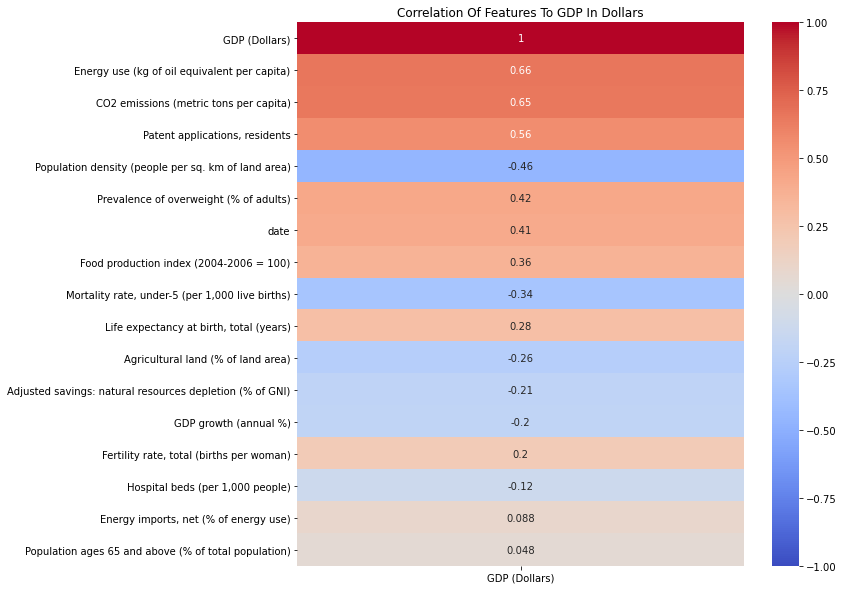

In [105]:
cor = df_multiple_countries["GDP (Dollars)"]
plt.subplots(figsize=(10,10)) 
correlation = df_multiple_countries.corr()[[df_multiple_countries.columns[0]]].sort_values(ascending=False, by = df_multiple_countries.columns[0], key=np.abs)
sns.heatmap(data= correlation,
            cmap= 'coolwarm',      
            annot= True,
            #xticklabels= "Predicted And Actual GDP Percent Change By Year (In Sample With Extra Features)",
            vmax= 1,
            vmin= -1);
plt.title("Correlation Of Features To GDP In Dollars");


Setting up my X and y

In [6]:
X_dollars = df_multiple_countries.drop(columns = ["GDP growth (annual %)", "GDP (Dollars)"])
y_dollars= df_multiple_countries["GDP (Dollars)"]

X_train_dollars, X_test_dollars, y_train_dollars, y_test_dollars = train_test_split(X_dollars, y_dollars, random_state = 42)

Predicting GDP in Dollars Using a Simple Linear Regression

In [7]:
lr_GDP = LinearRegression()
lr_GDP.fit(X_train_dollars, y_train_dollars)

LinearRegression()

R2 Score Printout

In [8]:
lr_GDP.score(X_train_dollars, y_train_dollars), lr_GDP.score(X_test_dollars, y_test_dollars)

(0.9732409185254227, 0.9233881976169362)

Mean Squared Error Printout

In [10]:
(mean_squared_error(y_test_dollars, lr_gdp_preds)) ** .5

1118335583274.2195

Listing out coeficients with interpretability

In [306]:
coefs_to_interpret = list(zip(X_dollars.columns, lr_GDP.coef_))

Creating a dictionary ordered by relative influence of each feature on GDP in dollars 

In [305]:
values = [val[1] for val in coefs_to_interpret]
keys = [val[0] for val in coefs_to_interpret]
dictionary = dict(zip(keys, values))

In [304]:
for key, value in sorted(dictionary.items(), key=lambda item: abs(item[1])):
    print("%s: %s" % (key, value))

Patent applications, residents: 13832398.857927516
Population density (people per sq. km of land area): 450151094.35272557
Energy use (kg of oil equivalent per capita): -1319943139.6335187
Energy imports, net (% of energy use): -38799742054.95187
Food production index (2004-2006 = 100): 66944611728.303856
Population ages 65 and above (% of total population): -102885934669.22662
Life expectancy at birth, total (years): -115513007154.64449
date: 146303252398.2569
Adjusted savings: natural resources depletion (% of GNI): -165377311523.52347
Hospital beds (per 1,000 people): 167608826383.97284
Agricultural land (% of land area): -167895773070.64215
Mortality rate, under-5 (per 1,000 live births): 211931190791.22794
Prevalence of overweight (% of adults): 254109580527.761
CO2 emissions (metric tons per capita): 707378554656.2297
Fertility rate, total (births per woman): 1680208495974.4988


Plot Bar Graph Of Coeficient Values

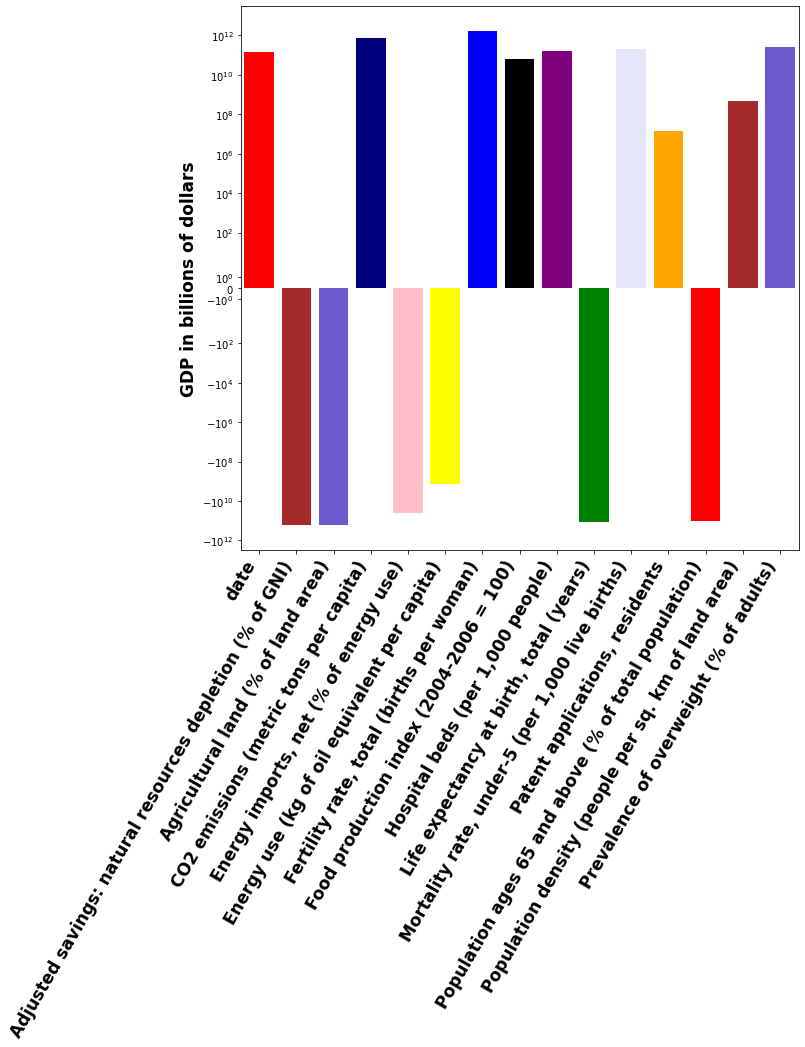

In [283]:
x_labels = [val[0] for val in coefs_to_interpret]
y_labels = [val[1] for val in coefs_to_interpret]
plt.figure(figsize=(10, 10))
ax = pd.Series(y_labels).plot(kind='bar')
ax.set_xticklabels(x_labels)
plt.xticks(color='black', rotation=60, fontweight='bold', fontsize='17', horizontalalignment='right')
plt.bar(x_labels, y_labels, color=['red', 'brown', "slateblue", "navy", "pink", "yellow", 'blue', 'black', 'purple', 'green', 'lavender', "orange"])
plt.yscale('symlog')
ax.set_ylabel("GDP in billions of dollars", color='black', fontweight='bold', fontsize='17')
plt.show();

Creating an Extra Trees Model

In [12]:
et = ExtraTreesRegressor(random_state = 42)

Gridsearching over hyperparameters

In [13]:
et_params = {
    'n_estimators': [100, 150], 
'max_depth': [3, 4, 5], 
'min_samples_split': [2, 3, 5],
'min_samples_leaf': [1, 2 ,3],
'max_features': ['auto', 'log2'],
'bootstrap': [True, False]}

gs_et = GridSearchCV(et, param_grid=et_params, cv=5, n_jobs = -2, verbose = True)
gs_et.fit(X_test_dollars, y_test_dollars)
print(gs_et.best_score_)
gs_et.best_params_

gs_et.score(X_train_dollars, y_train_dollars), gs_et.score(X_test_dollars, y_test_dollars)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 15 concurrent workers.
[Parallel(n_jobs=-2)]: Done  20 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-2)]: Done 170 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-2)]: Done 420 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-2)]: Done 770 tasks      | elapsed:   15.0s


0.9213039211160625


[Parallel(n_jobs=-2)]: Done 1080 out of 1080 | elapsed:   19.2s finished


(0.9314001230666619, 0.9955154398424121)

Generating Predictions

In [14]:
gs_et_preds = gs_et.predict(X_test_dollars)

Printout of Mean Squared Error

In [15]:
(mean_squared_error(y_test_dollars, gs_et_preds)) ** .5

270572859071.21048

In [133]:
gs_et.score(X_test_dollars, y_test_dollars)

0.9955154398424121

Graphing My Predictions Vs Actual GDP Values

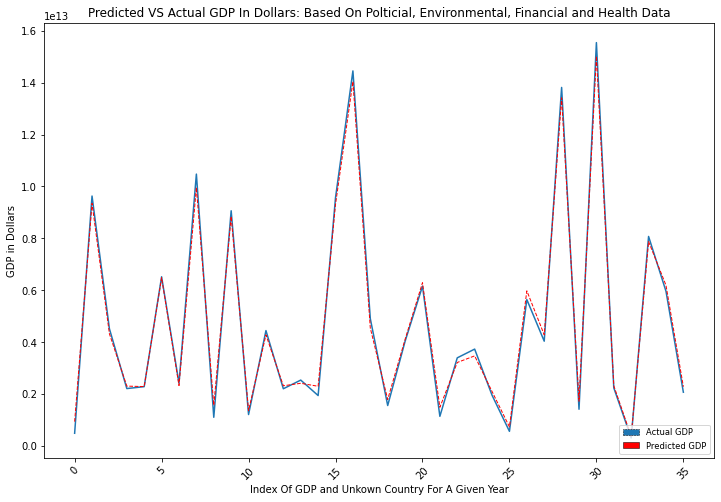

In [79]:
plt.figure (figsize=(12,8))
plt.xticks(rotation = 45)
plt.title("Predicted VS Actual GDP In Dollars: Based On Polticial, Environmental, Financial and Health Data")
plt.plot(y_test_dollars.reset_index()["GDP (Dollars)"])
plt.plot(gs_et_preds, lw=1, color='red', ls='dashed',label='Testing Predictions')
plt.xlabel("Index Of GDP and Unkown Country For A Given Year")
plt.ylabel("GDP in Dollars")
one = mpatches.Patch(facecolor='#1f77b4', ls='dashed', label='Actual GDP', linewidth = 0.5, edgecolor = 'black')
two = mpatches.Patch(facecolor='red', label = 'Predicted GDP', linewidth = 0.5, edgecolor = 'black')
legend = plt.legend(handles=[one, two], loc = 4, fontsize = 'small', fancybox = True)

Nueral Net Model

Redifining X and y

In [18]:
X_dollars = df_multiple_countries.drop(columns = ["GDP growth (annual %)", "GDP (Dollars)"])
y_dollars= df_multiple_countries["GDP (Dollars)"]
X_train_dollars, X_test_dollars, y_train_dollars, y_test_dollars = train_test_split(X_dollars, y_dollars, random_state = 42)

Scalling my Y 

In [19]:
yz_train_dollars = (y_train_dollars - np.mean(y_train_dollars))/np.std(y_train_dollars)
yz_test_dollars= (y_test_dollars - np.mean(y_test_dollars))/np.std(y_test_dollars)

Scaling the X features

In [20]:
ss = StandardScaler()
Xs_train_dollars = ss.fit_transform(X_train_dollars)
Xs_test_dollars= ss.transform(X_test_dollars)

Fitting My Nueral Net

In [122]:
optimizer = Adam(learning_rate = .0001)
lrelu = lambda x: relu(x, alpha=0.1)
#setting up 'blank canvas'
model = Sequential()
#input layer
model.add(Dense(64,
               input_shape = Xs_train_dollars[0].shape,
               activation = lrelu))
model.add(Dropout(0.2))
#hidden layer
model.add(Dense(32, activation = lrelu, kernel_regularizer=l2(0.001)))
#output layer
model.add(Dense(1, activation = 'linear'))
model.compile(loss = 'mse', optimizer = optimizer, metrics = ['mae'])
#early_stop = EarlyStopping(monitor='val_loss', min_delta=0, patience=1000, verbose=1, mode='auto')
history = model.fit(Xs_train_dollars, yz_train_dollars, validation_data = (Xs_test_dollars, yz_test_dollars.values), verbose = 0, epochs = 11000, batch_size = 2048)

Plotting My loss Function

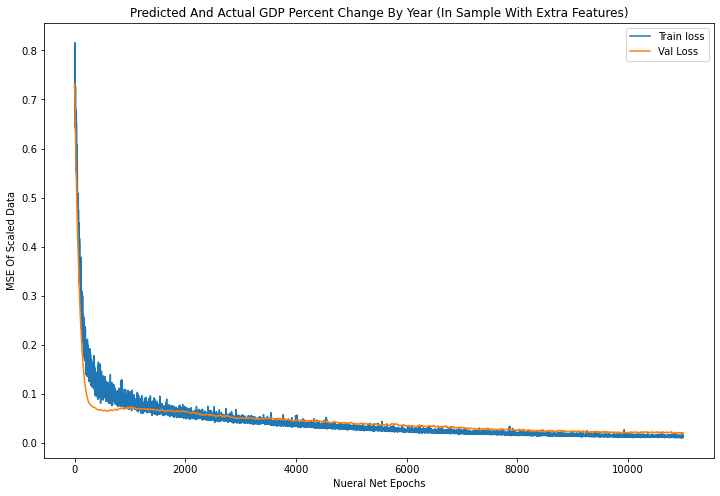

In [123]:
plt.figure (figsize=(12,8))
plt.title("Predicted And Actual GDP Percent Change By Year (In Sample With Extra Features)")
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel("Nueral Net Epochs")
plt.ylabel("MSE Of Scaled Data")
plt.legend();

Generating Predictions

In [124]:
y_preds = model.predict(Xs_test_dollars)

Reversing the z score standardization to create interpretable y preds

In [125]:
interpretable_y_preds = y_preds*np.std(y_test_dollars)+np.mean(y_test_dollars)

Plotting My Predictions Vs Actual Values in Testing Data

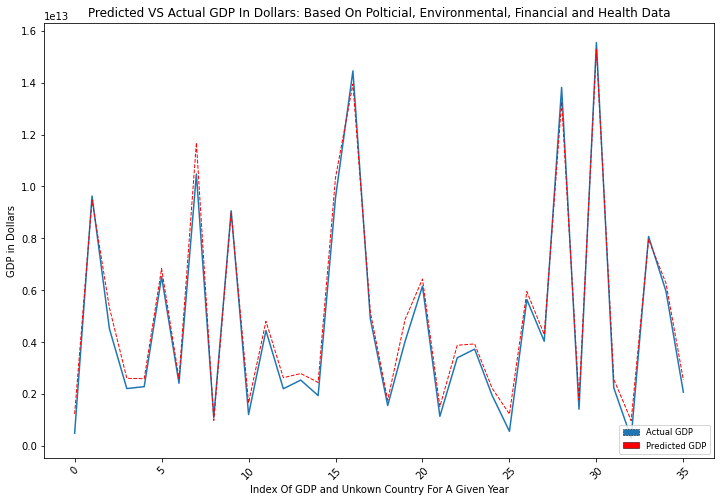

In [126]:
plt.figure (figsize=(12,8))
plt.xticks(rotation = 45)
plt.title("Predicted VS Actual GDP In Dollars: Based On Polticial, Environmental, Financial and Health Data")
plt.xlabel("Index Of GDP and Unkown Country For A Given Year")
plt.ylabel("GDP in Dollars")
plt.plot(y_test_dollars.reset_index()["GDP (Dollars)"])
plt.plot(interpretable_y_preds, lw=1, color='red', ls='dashed',label='Testing Predictions')
one = mpatches.Patch(facecolor='#1f77b4', ls='dashed', label='Actual GDP', linewidth = 0.5, edgecolor = 'black')
two = mpatches.Patch(facecolor='red', label = 'Predicted GDP', linewidth = 0.5, edgecolor = 'black')
legend = plt.legend(handles=[one, two], loc = 4, fontsize = 'small', fancybox = True)

Printout Of Mean Squared Error

In [127]:
(mean_squared_error(y_test_dollars, interpretable_y_preds)) ** .5

475978558494.0227